### Setup environment

In [1]:
!pip install torch torchvision matplotlib scikit-learn gdown -q
!git clone https://github.com/facebookresearch/dinov3.git -q # clone divov3
!gdown 1gnn9uHZp1VcWjt5bWjw-X2lWjuCMWdRN -q # download dinov3_vitl16_pretrain weights

import os, math, sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import requests
import cv2

In [2]:
import kagglehub

dataset = kagglehub.dataset_download("hunglq/dota-small-2")
print("Path to dataset files:", dataset)

dst = "/content/dota"
if os.path.islink(dst) or os.path.exists(dst):
    os.unlink(dst)

os.symlink(dataset, dst)
print("Symlink created at:", dst)

100%|██████████| 1.98G/1.98G [00:17<00:00, 121MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hunglq/dota-small-2/versions/1
Symlink created at: /content/dota


### Load DINOv3

In [3]:
REPO_DIR = "/content/dinov3"
WEIGHTS_PATH = "/content/dinov3_vitl16_pretrain_sat493m-eadcf0ff.pth"

backbone_model = torch.hub.load(REPO_DIR, 'dinov3_vitl16', source='local', weights=WEIGHTS_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone_model.to(device)
backbone_model.eval() # evaluation mode

Downloading: "file:///content/dinov3_vitl16_pretrain_sat493m-eadcf0ff.pth" to /root/.cache/torch/hub/checkpoints/dinov3_vitl16_pretrain_sat493m-eadcf0ff.pth


100%|██████████| 1.13G/1.13G [00:12<00:00, 94.2MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-23): 24 x SelfAttentionBlock(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm)

### Small DOTA Dataset

In [33]:
class UAVDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images_paths = [os.path.join(images_dir, f) for f in os.listdir(images_dir)]
        self.labels_paths = [os.path.join(labels_dir, f) for f in os.listdir(labels_dir)]
        self.transforms = transforms

        # Mapping category names to integer labels
        all_classes = set()
        for f in os.listdir(labels_dir):
            with open(os.path.join(labels_dir, f)) as file:
                for line in file:
                    category = line.strip().split()[8]
                    all_classes.add(category)

        self.class_mapping = {c: i+1 for i, c in enumerate(sorted(all_classes))}

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.images_paths[idx]
        img = Image.open(img_path).convert("RGB")

        # Load annotations
        label_path = self.labels_paths[idx]
        boxes = []
        labels = []
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                coords = [float(v) for v in parts[:8]]
                xmin = min(coords[0::2])
                ymin = min(coords[1::2])
                xmax = max(coords[0::2])
                ymax = max(coords[1::2])
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.class_mapping[parts[8]])

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

from torchvision import transforms

# Transform function
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

train_dataset = UAVDataset(
    "/content/dota/test_ds_2/train/images",
    "/content/dota/test_ds_2/train/labelTxt",
    transforms=transform
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [5]:
print(train_dataset.class_mapping)

{'baseball-diamond': 1, 'basketball-court': 2, 'bridge': 3, 'ground-track-field': 4, 'harbor': 5, 'helicopter': 6, 'large-vehicle': 7, 'plane': 8, 'roundabout': 9, 'ship': 10, 'small-vehicle': 11, 'soccer-ball-field': 12, 'storage-tank': 13, 'swimming-pool': 14, 'tennis-court': 15}


### Wrap DINOv3 Backbone for Faster R-CNN

In [34]:
class DINOv3Backbone(nn.Module):
    def __init__(self, backbone_model, out_channels=1024, patch_size = 16):
      super().__init__()
      self.model = backbone_model
      self.out_channels = out_channels
      self.patch_size = patch_size

    def forward(self, x):
        B, C, H, W = x.shape

        # Get patch embeddings: [B, N, C]
        features = self.model.get_intermediate_layers(x, n=1)[0]  # [B, N, C]

        # Remove CLS token
        features = features[:, 1:, :]  # [B, N-1, C]
        B, N_minus1, C = features.shape

        # Compute h, w from number of patches
        h = int(math.sqrt(N_minus1))
        w = N_minus1 // h

        # Pad if needed
        pad_tokens = (h * w) - N_minus1
        if pad_tokens > 0:
            pad = features[:, -1:, :].repeat(1, pad_tokens, 1)
            features = torch.cat([features, pad], dim=1)

        # Reshape to spatial map [B, C, H, W]
        features = features.permute(0, 2, 1).reshape(B, C, h, w)

        return {"feat0": features}

backbone = DINOv3Backbone(backbone_model)

### add Faster R-CNN Detection Head

In [35]:
# Define anchor generator
anchor_generator = AnchorGenerator(
    sizes=((4, 8, 16, 32, 64),),  # smaller anchors for DOTA
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# Define ROI pooler
from torchvision.ops import MultiScaleRoIAlign
roi_pooler = MultiScaleRoIAlign(featmap_names=["feat0"],
                                output_size=7,
                                sampling_ratio=2)

# Define Faster R-CNN model
model = FasterRCNN(
    backbone,
    num_classes = len(train_dataset.class_mapping) + 1,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

### Few-shot Fine-tuning

- Freeze most of DINOv3 weights → only fine-tune the detection head.
- This prevents overfitting since UAV dataset is small.

In [36]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

# Freeze partial backbone
# for name, param in backbone.named_parameters():
#     if "blocks.10" in name or "blocks.11" in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

# Freeze full
for name, param in backbone.named_parameters():
    param.requires_grad = False

# Train detection head only
params = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(params, lr=0.005, weight_decay=1e-4)


### Train

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using:", device)
model.to(device)

num_epochs = 10
scaler = torch.amp.GradScaler('cuda')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    count = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        count += 1

    epoch_loss = running_loss / count
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Using: cuda
Epoch 1/10, Loss: 63.1383
Epoch 2/10, Loss: 55.7482
Epoch 3/10, Loss: 54.9141
Epoch 4/10, Loss: 55.3977
Epoch 5/10, Loss: 55.5968
Epoch 6/10, Loss: 54.5889
Epoch 7/10, Loss: 52.4841
Epoch 8/10, Loss: 53.6353
Epoch 9/10, Loss: 55.3671
Epoch 10/10, Loss: 53.6232


In [27]:
# import gc  # Python garbage collector

# # Delete unnecessary variables
# del model
# del images
# del targets
# del loss_dict

# # Run garbage collector
# gc.collect()

# # Empty CUDA cache
# torch.cuda.empty_cache()

# # check GPU memory
# print(torch.cuda.memory_summary(device=None, abbreviated=True))


### Visualization

Scores: [0.30776298 0.2916406  0.2882863  0.28390303 0.27459353 0.24616162
 0.19655772 0.17974852 0.14587064 0.14479372]
Scores: [0.05381062 0.05298989 0.05199921 0.05114522]
Scores: [0.45836803 0.43307605 0.30143496 0.27330667 0.2587518  0.21759596
 0.19554281 0.1954435  0.16884749 0.16398539]
Scores: [0.13532719 0.08144855 0.06808715 0.06496364]
Scores: [0.24680899 0.24680899 0.24680899 0.24680899 0.24680899 0.24680899
 0.17312725 0.17312725 0.17312725 0.17312725]


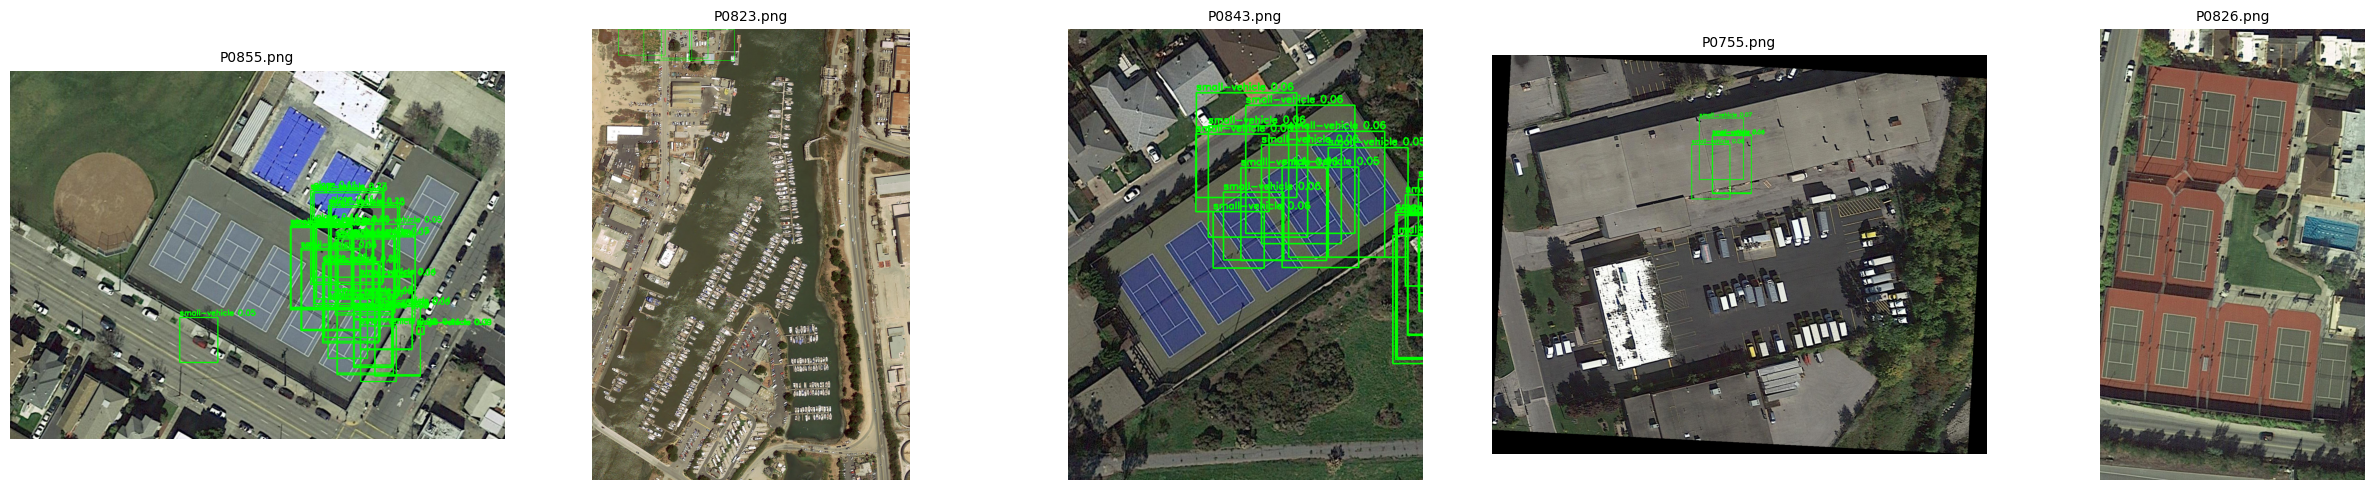

In [41]:
import random

model.eval()
test_img_dir = "/content/dota/test_ds_2/test/images"

num_images = 5

all_imgs = os.listdir(test_img_dir)
sample_imgs = random.sample(all_imgs, min(num_images, len(all_imgs)))

class_names = ["__background__"]  # index 0 for background

for class_name, label in sorted(train_dataset.class_mapping.items(), key=lambda x: x[1]):
    class_names.append(class_name)

transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor()
])

# Plot
fig, axes = plt.subplots(1, len(sample_imgs), figsize=(5 * len(sample_imgs), 5))

if len(sample_imgs) == 1:
    axes = [axes]

for ax, img_name in zip(axes, sample_imgs):
    img_path = os.path.join(test_img_dir, img_name)

    # Load image
    pil_img = Image.open(img_path).convert("RGB")
    tensor_img = transform(pil_img).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        preds = model(tensor_img)

    boxes = preds[0]["boxes"].cpu().numpy()
    scores = preds[0]["scores"].cpu().numpy()
    labels = preds[0]["labels"].cpu().numpy()

    # Convert PIL -> NumPy
    img = np.array(pil_img)

    # Draw boxes
    for (x1, y1, x2, y2), score, label in zip(boxes, scores, labels):
        if score > 0.05:
            class_name = class_names[label]
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(img, f"{class_name} {score:.2f}", (int(x1), int(y1)-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Show result
    ax.imshow(img)
    ax.set_title(img_name, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()